In [1]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots","PyCall","JSON","JLD2","FileIO","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using Statistics: mean
using Plots;
using FileIO;
using MAT;
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, Param,progress, sgd,dropout, relu,
Data,sigm, xavier,gpu,softmax
import Knet:param,param0
using Images;
using PyCall,JSON,JLD2,Random
@pyimport numpy as np 

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:400
└ @ PyCall /home/ege/.julia/packages/PyCall/RQjD7/src/PyCall.jl:400


In [2]:
atype()=(gpu() >= 0 ? KnetArray{Float32} : Array{Float32})
param(d...; init=xavier, atype=atype())=Param(atype(init(d...)))
param0(d...; atype=atype())=param(d...; init=zeros, atype=atype)

param0 (generic function with 1 method)

In [3]:
function image_data(img,image_size)
    global _imgcache
    if !@isdefined(_imgcache); _imgcache = Dict(); end
        a0=img
        new_size = ntuple(i->div(size(a0,i)*image_size,minimum(size(a0))),2)
        a1 = Images.imresize(a0, new_size)
        i1 = div(size(a1,1)-image_size,2)
        j1 = div(size(a1,2)-image_size,2)
        b1 = a1[i1+1:i1+image_size,j1+1:j1+image_size]
        b1 = convert(Array{FixedPointNumbers.Normed{UInt8,8},2}, b1)
        d1 = convert(atype(), b1)
        e1 = reshape(d1[:,:,1], (image_size,image_size,1,1))
        f1 = (255 * e1)
        g1 = permutedims(f1, [2,1,3,4])
    return g1
end

image_data (generic function with 1 method)

In [4]:
function read_data(data_path,image_size)
i=1
first_r=true
y=[]
x=0
folders=readdir(data_path)
for class in folders
    println("Class number ",i)
    directory=string(data_path,"/",class)
    for img in readdir(directory)
            
        arr_img=load(string(directory,"/",img))
            
        arr_img=image_data(arr_img,image_size)   
        #=arr_img=Gray.(arr_img)
        arr_img=convert(Array{Float32},arr_img)
        arr_img=reshape(arr_img,(72,72,1,1))=#
        arr_img=convert(atype(),arr_img)
        label=zeros(size(folders))
        label[i]=1
        if first_r==false
            x=cat(arr_img,x,dims=4)
        else
            #global x=cat(arr_img,dims=4)
            x=cat(arr_img,dims=4)
        end
        push!(y,i)
        first_r=false
    end
    i+=1
    end
println(size(y))
println(size(x))
return x,y;
end

read_data (generic function with 1 method)

In [5]:
struct Chain
    layers
    Chain(layers...)=new(layers)
end
(c::Chain)(x) = (for layer in c.layers; x=layer(x) end;x)#if printsize==1 println(size(x)) end;end; x) #layerların çıktılarını hesaplayıp son layerın çıktısını veriyor
(c::Chain)(x,y)=nll(c(x),y) #loss
(c::Chain)(d::Data)=mean(c(x,y) for (x,y) in d) 

In [6]:
struct Fully; w;b;func;end;
Fully(m::Int,n::Int,func)=Fully(param(n,m),param0(n),func)
(ful::Fully)(x)=ful.func.(ful.w*x.+ful.b)

In [7]:
struct Conv_vgg; w;b;func; #vgg'den weightleri alan conv
    Conv_vgg(w,b)=new(Param(w),Param(b),relu)
    Conv_vgg(w,b,func)=new(Param(w),Param(b),func)
    end;
(c::Conv_vgg)(x)=c.func.(conv4(c.w,x,padding=1,mode=1).+c.b)
#(c::Conv)(x)=conv4(c.w,x,padding=1,mode=1).+c.b

In [8]:
struct Conv;w;b;pad;func;end; #eğitilecek conv layerlar
Conv(m::Int,n::Int,k_in::Int,k_out::Int,pad,func)=Conv(param(m,n,k_in,k_out),param0(1,1,k_out,1),pad,func)
(c::Conv)(x)=c.func.(conv4(c.w,x,padding=c.pad,mode=1).+c.b)

In [9]:
struct Pool end
(p::Pool)(x)=pool(x)

In [10]:
struct Dense; w;b;func;
    Dense(w,b)=new(Param(w),Param(b),relu)
    Dense(w,b,func)=new(Param(w),Param(b),func) #dosyadan okunan weigtler
    Dense(x::Int,y::Int,func)=new(param(y,x),param0(y),func) #random atanan weigthler
    end;
function (den::Dense)(x) 
    matrix_multip=den.w*mat(x).+den.b
    if den.func==relu
        return den.func.(matrix_multip)
    else
        return den.func(matrix_multip)
    end
end

In [11]:
weight_dict=matread("imagenet-vgg-no-fc+conv5-16.mat")
layers=weight_dict["layers"]
w_arr=[]
for layer in layers
    if occursin("conv",layer["name"])
        w=layer["weights"]
        push!(w_arr,convert(atype(),w[1]))
        b=reshape(w[2], (1,1,length(w[2]),1))
        push!(w_arr,convert(atype(),b))
        elseif occursin("fc",layer["name"])
            w=layer["weights"]
            w[1] = transpose(mat(w[1]))
            push!(w_arr,convert(atype(),w[1]))
            push!(w_arr,convert(atype(),w[2]))
        end
end

In [13]:
w_gray=w_arr[1][:,:,1,:]+w_arr[1][:,:,2,:]+w_arr[1][:,:,3,:];
w_gray=reshape(w_gray,(3,3,1,64));
w_gray=convert(atype(),w_gray)
summary(w_gray)

"3×3×1×64 Array{Float32,4}"

In [14]:
Vgg_model=Chain(Conv_vgg(w_gray,w_arr[2]),Conv_vgg(w_arr[3],w_arr[4]),Pool(),  
    Conv_vgg(w_arr[5],w_arr[6]),Conv_vgg(w_arr[7],w_arr[8]),Pool(),              
    Conv_vgg(w_arr[9],w_arr[10]),Conv_vgg(w_arr[11],w_arr[12]),Conv_vgg(w_arr[13],w_arr[14]),Pool(),       
    Conv_vgg(w_arr[15],w_arr[16]),Conv_vgg(w_arr[17],w_arr[18]),Conv_vgg(w_arr[19],w_arr[20]),Pool(),
    Conv(7,7,512,256,3,relu),Conv(3,3,256,256,1,relu),Conv(3,3,256,512,1,relu),Pool(),
    Dense(512*2*2,500,relu),
    Dense(500,100,relu),Dense(100,6,identity));

In [21]:
train_x,train_y=read_data("vgg-augment-little/train",72);
test_x,test_y=read_data("vgg-augment-little/test",72);

Class number 1
Class number 2
Class number 3
Class number 4
Class number 5
Class number 6
(60,)
(72, 72, 1, 60)
Class number 1
Class number 2
Class number 3
Class number 4
Class number 5
Class number 6
(18,)
(72, 72, 1, 18)


In [23]:
batch_size=10
batch_train=Knet.minibatch(train_x,train_y,batch_size,xtype=Array{Float32},ytype=Array{Int32});
batch_test=Knet.minibatch(test_x,test_y,batch_size,xtype=Array{Float32},ytype=Array{Int32});

In [18]:
# For running experiments
function trainresults2(model,dtrn,dtst,ep,optimizer,learning_r)
    train_iter(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
                
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in train_iter(length(dtrn), progress(optimizer(model,repeat(dtrn,ep),lr=learning_r))))
        r = reshape(collect(Float32,flatten(r)),(4,:))          
    return r
end

trainresults2 (generic function with 1 method)

In [25]:
ep=3
result=trainresults2(Vgg_model,batch_train,batch_test,ep,sgd,0.0001);

1.47e+00  100.00%┣████████████████████████┫ 18/18 [05:22/05:22, 17.89s/i]


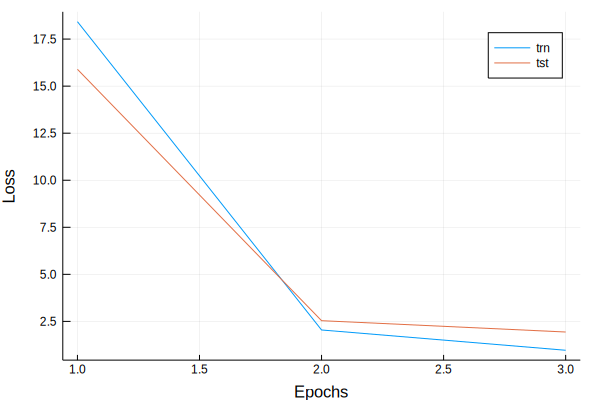

In [27]:
plot([result[1,:], result[2,:]],
     labels=[:trn :tst],xlabel="Epochs",ylabel="Loss")

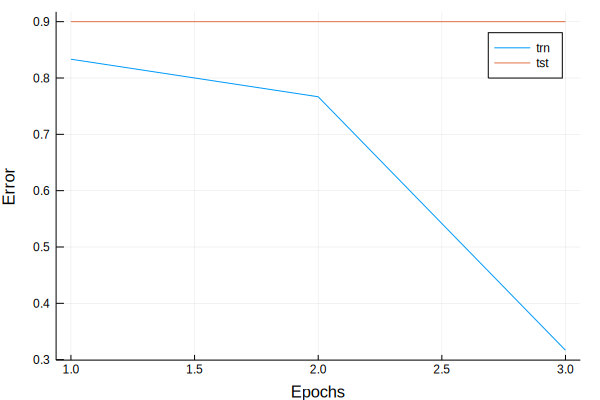

In [28]:
plot([result[3,:], result[4,:]],
     labels=[:trn :tst],xlabel="Epochs",ylabel="Error")